In [1]:
# !pip3 install transformers

In [63]:
import pandas as pd

##### This Tasks (Tuning Model (bert-base-uncased) from Hugging Face):
- Add more dataset and new labels
- Use TikTok + YouTube total 200 messages
  - 180 messages for train and 20 messages for test

In [75]:
df = pd.read_csv("../Dataset/Annotate_Dataset/comments_annotated.csv")
texts = df['Comment'][:180].tolist()
labels = df['Type_Nalin'][:180].tolist()

In [83]:
import pandas as pd

df = pd.read_csv("../Dataset/Annotate_Dataset/comments_annotated.csv")
# texts = df['Comment'][:180].tolist()
# labels = df['Type_Nalin'][:180].tolist()
texts = df['Comment'][:200].tolist()
labels = df['Type_Nalin'][:200].tolist()

# Mapping dictionary to combine labels
label_mapping = {
    'respect': 'sweet',
    'excitement': 'sweet',
    'sweet': 'sweet',
    'rebellious' : 'threat',
    'accusatory' : 'threat',
    'derogatory' : 'mocking',
    'disgust' : 'Discrimination',

    # Add other labels if needed
}

# Update labels based on the mapping dictionary
labels = [label_mapping[label] if label in label_mapping else label for label in labels]


In [84]:
set(labels)

{'Discrimination',
 'acknowledgement',
 'admiration',
 'amazement',
 'amusement',
 'concerning',
 'criticism',
 'discriminatory',
 'humorous',
 'mocking',
 'sarcastic',
 'support',
 'sweet',
 'threat'}

In [85]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


best_valid_loss = float('inf')  # Initialize with a high value

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize the texts
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Split the data into training and validation sets
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']


train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks = train_test_split(
    input_ids, encoded_labels, attention_masks, test_size=0.2, random_state=42
)

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
model.to(device)

# Create data loaders
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

val_data = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels))
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)
        
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    val_loss = 0.0
    predictions = []

    for batch in val_loader:
        input_ids, attention_masks, labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        
        logits = outputs.logits
        val_loss += loss_fn(logits, labels).item()

        # Get predicted labels
        _, predicted_labels = torch.max(logits, 1)
        predictions.extend(predicted_labels.tolist())

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Check if current model has the best validation loss
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        # Save the model
        torch.save(model.state_dict(), '../Model/deep_model/multiclassifier.pt')
        print('Best model saved.')


    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

# Load the best model
model.load_state_dict(torch.load('../Model/deep_model/multiclassifier.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Best model saved.
Epoch 1: Train Loss: 2.6722 | Val Loss: 2.6545
Epoch 2: Train Loss: 2.5175 | Val Loss: 2.6667
Best model saved.
Epoch 3: Train Loss: 2.3363 | Val Loss: 2.6208
Epoch 4: Train Loss: 2.1285 | Val Loss: 2.6454
Best model saved.
Epoch 5: Train Loss: 1.8999 | Val Loss: 2.6189
Epoch 6: Train Loss: 1.6476 | Val Loss: 2.7110
Epoch 7: Train Loss: 1.3933 | Val Loss: 2.8674
Epoch 8: Train Loss: 1.2053 | Val Loss: 2.8012
Epoch 9: Train Loss: 0.9494 | Val Loss: 2.8167
Epoch 10: Train Loss: 0.7674 | Val Loss: 2.8580


<All keys matched successfully>

### Test Model with 20 Sentences

In [86]:
# new_texts = [
#     '🐀 🐀 🐀 everywhere 😏',
#     'WWE Entrance 💀💀💀',
#     '👍💯😝💯👍',
#     'Daniiiii oh my😭😭😍😍',
#     '👍 😅 Ima gonna try it on some cuties like you Dani ! ~♡',
# ]
new_texts = [
    "🤤I need a bitch thats gon pay all my bills I don’t like broke women 🤢🚮😷🚮🤧 ",
    "When you're livin life on the edge but safety always comes first... 🌚",
    "DEPORT RAPEFUGEE'S!!! 🤬🤬🤬🤬🤬🤬🤬🤬",
    "REFUGEES NOT WELCOME 👊🏻👊🏻👊🏻",
    "@user stop controlling me!!!!! 😝😝😝😝😝",
    "— I’m fckin dead @user 😹💀 I fckin miss you hoe slut skank beetch 😘💖🤞🏻",
    "'Replaceable' best describes your life 🤗 ",
    "When they REALLY don't want you to advertise 😂😂😂",
]

df = pd.read_csv("../Dataset/Annotate_Dataset/comments_annotated.csv")
# new_texts = df['Comment'][170:].tolist()
new_labels = df['Type_Nalin'][180:].tolist()

# Tokenize the new texts
new_encoded_inputs = tokenizer(new_texts, padding=True, truncation=True, return_tensors='pt')

new_input_ids = new_encoded_inputs['input_ids']
new_attention_masks = new_encoded_inputs['attention_mask']


In [87]:
set(new_labels)

{'acknowledgement',
 'admiration',
 'amazement',
 'amusement',
 'concerning',
 'disgust',
 'humorous',
 'sarcastic',
 'support'}

In [88]:
new_data = TensorDataset(new_input_ids, new_attention_masks)
new_loader = DataLoader(new_data, batch_size=4, shuffle=False)


In [89]:
model.eval()
new_predictions = []

for batch in new_loader:
    input_ids, attention_masks = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
    
    logits = outputs.logits
    _, predicted_labels = torch.max(logits, 1)
    new_predictions.extend(predicted_labels.tolist())

# Convert the predicted labels back to their original class labels
new_predicted_labels = label_encoder.inverse_transform(new_predictions)

print(new_predicted_labels)
print(len(new_labels))


['humorous' 'sarcastic' 'sarcastic' 'sarcastic' 'amusement' 'mocking'
 'criticism' 'mocking']
20


In [41]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(new_labels, new_predicted_labels)
print(report)


                 precision    recall  f1-score   support

acknowledgement       0.00      0.00      0.00         2
     admiration       0.00      0.00      0.00         3
      amazement       0.00      0.00      0.00         4
      amusement       0.00      0.00      0.00         3
     concerning       0.00      0.00      0.00         1
      criticism       0.00      0.00      0.00         2
        disgust       0.00      0.00      0.00         1
       humorous       0.00      0.00      0.00         5
        mocking       0.00      0.00      0.00         1
      sarcastic       0.08      0.25      0.12         4
        support       0.00      0.00      0.00         4
          sweet       0.00      0.00      0.00         0

       accuracy                           0.03        30
      macro avg       0.01      0.02      0.01        30
   weighted avg       0.01      0.03      0.02        30



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

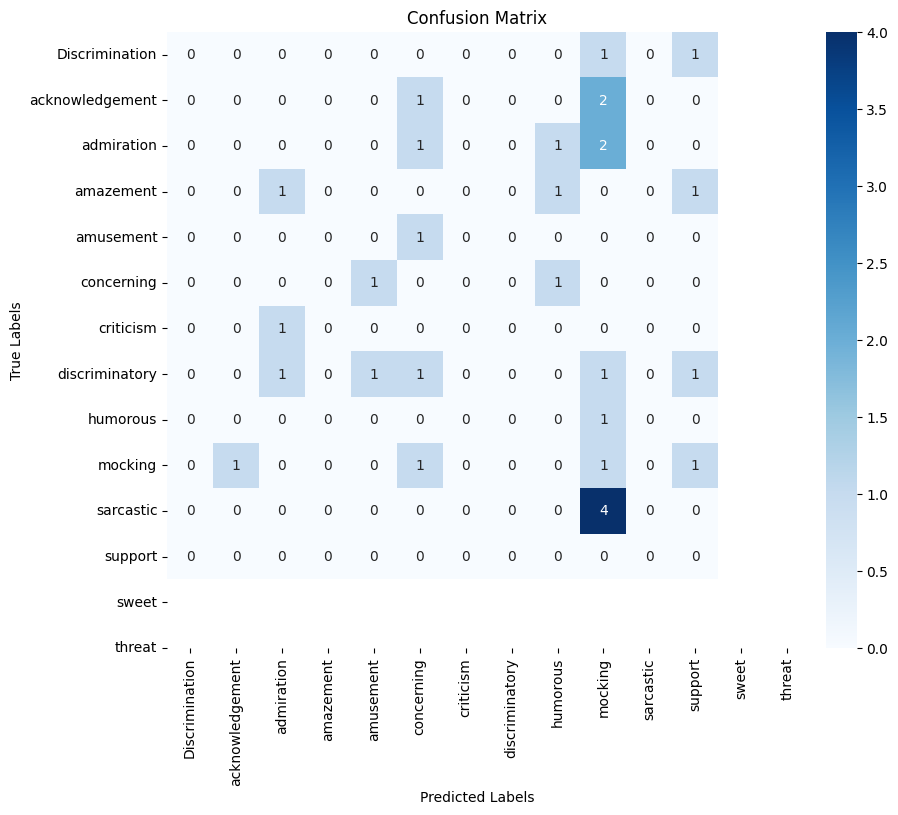

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Generate the confusion matrix
cm = confusion_matrix(new_labels, new_predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

